## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict 
from sklearn import metrics, model_selection
from torch.optim import Adam

sys.path.append(os.path.abspath(''))

import utils.more_torch_functions as mtf
import datasets

from utils.custom_activations import StepActivation
from utils.modules import Parallel, MaxLayer
from utils.misc import cross_valid, combine_prompts, cov_score, get_current_epoch

# torch.autograd.set_detect_anomaly(True)

## Load data

In [2]:
np_x, np_y = datasets.MnistDataset.get_dataset(balancing=True, keep_label=['0', '1'])
x_data, y_data = torch.Tensor(np_x), torch.Tensor(np_y)
input_size = x_data.size(1)
print(x_data.size())

torch.Size([11846, 28, 28])


## Hooks

In [3]:
intermediate_outputs = {}
def get_intermediate_outputs_batch(name):
    epoch = -1
    combined_output = None
    def hook(model, input, output):
        nonlocal epoch, combined_output
        new_epoch = get_current_epoch()
        if new_epoch != epoch:
            combined_output = OrderedDict()
            epoch = new_epoch

        for k, v in output.items():
            combined_output[k] = torch.concat([combined_output.get(k, torch.Tensor([])), v])

        if model.training:
            intermediate_outputs.setdefault(name, dict())["train"] = combined_output
        else:
            intermediate_outputs.setdefault(name, dict())["valid"] = combined_output
    return hook

def true_label_for_backward(train, valid):
    def hook(model, input):
        if model.training:
            model.true_labels = train
        else:
            model.true_labels = valid
    return hook

# créer hook fonction de perte pour meilleur backward ? (comparer individuellement les sorties des réseaux ???)

## Networks

### Network parts

In [4]:
class ApproxConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1,1,3,1)),
            ('a1', StepActivation()),
            ('mp1', nn.MaxPool2d(2)),
            ('conv2', nn.Conv2d(1,1,3,1)),
            ('a2', StepActivation()),
            ('mp2', nn.MaxPool2d(2)),
            ('flatten', nn.Flatten()),
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(5*5,1)), # Too large for compiling
            ('afc', StepActivation()),
        ]))

    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)

        return x

class BigConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(1,1,3,1)),
            ('a1', nn.ReLU()),
            ('conv2', nn.Conv2d(1,1,3,1)),
            ('a2', nn.ReLU()),
            ('conv3', nn.Conv2d(1,1,3,1)),
            ('a3', nn.ReLU()),
            ('flatten', nn.Flatten()),
        ]))

        self.fc = nn.Sequential(OrderedDict([
            ('fc', nn.Linear(22*22,1)),
            ('afc', StepActivation()),
        ]))
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.fc(x)

        return x

### New Network definition

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(OrderedDict([
            ('nets', Parallel(OrderedDict([
                # ('cnn', BigConvNet()),
                ('apx1', ApproxConvNet()),
            ]))),
            ('or_', MaxLayer()),
        ]))

    def forward(self, input):
        return self.net(input)

## Network evaluation

In [6]:
model = ConvNet()
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

model.net.nets.register_forward_hook(get_intermediate_outputs_batch("parallel_out"))

lr = 0.001
num_epochs = 50
batch_size = 64
num_folds = 10

skf = model_selection.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=8)
convnet_split_res = cross_valid(x_data, y_data, model, criterion, optimizer, skf, batch_size=batch_size, max_epoch=10)

nn_children = [name for name, _ in model.net.nets.named_children()]
dict_metrics = {(modelname, metric, key): list() for modelname in ["net"] + nn_children
                for metric in ("f1score", "coverage0", "coverage1") for key in ("valid", "train")}

for i, (train_pred, train_true, valid_pred, valid_true) in enumerate(convnet_split_res):
    out_nns = intermediate_outputs["parallel_out"]
    for d in out_nns.values():
        for k, v in d.items():
            d[k] = v.detach().round()

    f1prompts = []
    covprompts = []
    sep_model = f"{'|':^9}"
    for k, pred, true in [["valid", valid_pred, valid_true], ["train", train_pred, train_true]]:
        net_f1_score = metrics.f1_score(true, pred, average="binary")
        net_cov_score = cov_score(true, pred)
        dict_metrics[('net', 'f1score', k)].append(net_f1_score)
        dict_metrics[('net', 'coverage1', k)].append(net_cov_score[1])
        dict_metrics[('net', 'coverage0', k)].append(net_cov_score[0])
        covprompts.append(f"{'Net':<15}{net_cov_score[0]:.3f}{sep_model}{'Net':<15}{net_cov_score[1]:.3f}")

        prev_modelname = 'Net'
        prev_f1_score = net_f1_score

        for c, cname in enumerate(nn_children):
            modelname = 'Big Network'if c==0 else f'Approx {c}'
            model_pred = out_nns[k][cname]

            model_f1_score = metrics.f1_score(true, model_pred, average="binary")
            model_cov_score = cov_score(true, model_pred)

            if c%2==0:
                f1prompts.append(f"{prev_modelname:<15}{prev_f1_score:.3f}{sep_model}{modelname:<15}{model_f1_score:.3f}")
            else:
                prev_modelname = modelname
                prev_f1_score = model_f1_score
            covprompts.append(f"{modelname:<15}{model_cov_score[0]:.3f}{sep_model}{modelname:<15}{model_cov_score[1]:.3f}")

            dict_metrics[(cname, 'f1score', k)].append(model_f1_score)
            dict_metrics[(cname, 'coverage1', k)].append(model_cov_score[1])
            dict_metrics[(cname, 'coverage0', k)].append(model_cov_score[0])

        if c%2:
            f1prompts.append(f"{modelname:<15}{model_f1_score:.3f}{sep_model}{'':<20}")

    sep_tv = f"{'||':^10}"
    print(f"Fold {i+1:3} :            {'Valid':^49}{sep_tv}{'Train':^49}",
          f"\tF1 score      {combine_prompts(f1prompts, sep_tv)}",
          f"\tCoverage      {combine_prompts(covprompts, sep_tv)}",
          sep='\n')

Fold   1 :                                  Valid                          ||                          Train                      
	F1 score      Net            0.994    |    Big Network    0.994    ||    Net            0.499    |    Big Network    0.499
	Coverage      Net            0.995    |    Net            0.993    ||    Net            0.496    |    Net            0.499
	              Big Network    0.995    |    Big Network    0.993    ||    Big Network    0.496    |    Big Network    0.499
Fold   2 :                                  Valid                          ||                          Train                      
	F1 score      Net            0.996    |    Big Network    0.996    ||    Net            0.492    |    Big Network    0.492
	Coverage      Net            0.995    |    Net            0.997    ||    Net            0.493    |    Net            0.492
	              Big Network    0.995    |    Big Network    0.997    ||    Big Network    0.493    |    Big Network    

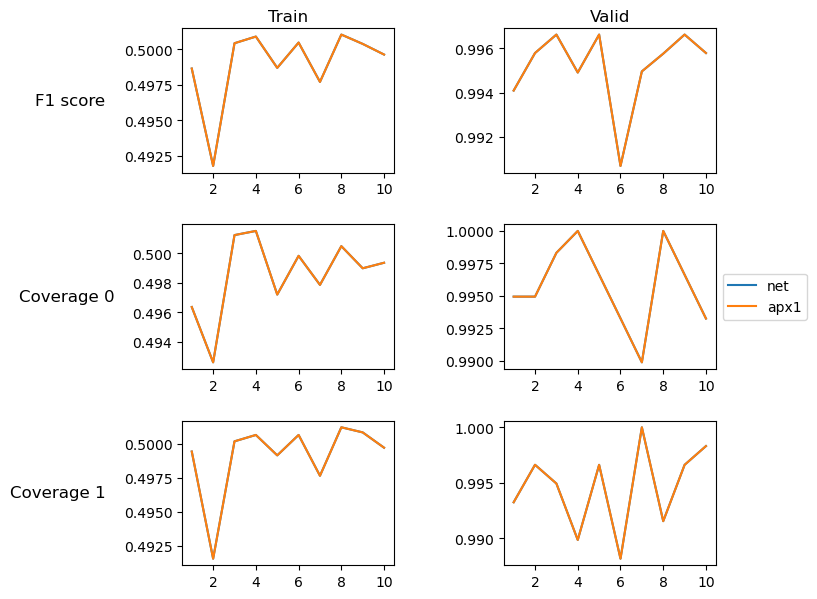

In [7]:
fig, axs = plt.subplots(3,2)

x_axis = list(range(1, num_folds+1))
mtypeconv = {"f1score": 0, "coverage0": 1, "coverage1": 2}
dtypeconv = {"train": 0, "valid": 1}
for ((modelname, metrictype, dataset), metric) in dict_metrics.items():
    ax = axs[mtypeconv[metrictype], dtypeconv[dataset]]
    ax.plot(x_axis, metric, label=modelname)
    # ax.set_ylim(0,1)

axs[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

cols = ["Train", "Valid"]
rows = ["F1 score", "Coverage 0", "Coverage 1"]

pad = 5
for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
fig.subplots_adjust(left=0, top=1.2)